# Long jupyter notebook for TDT4173 - Modern machine learning in practice - fall 2024 
Group number: 8 \
Group id kaggle: [8] Admiral P(redictor) \
Group members(student number): André Virani(525432), Peder Aas Vårheim(564051) and Markus Sandnes(544087)



## Introduction

In this notebook we have implemented two machine learning models for predicting vessel trajectories based on AIS-data provided in the course TDT4173. The notebook includes exploratory data analysis, preprocessing, feature engineering, predictors, and feature importance analysis. The test score is validated through kaggle (https://www.kaggle.com/competitions/ais-vessel-trajectory-prediction/leaderboard#). 

Since our group has little experience with machine learning we approached the project with simple models and focus on data preparation. We found the project quite difficult, but equaly rewarding when we got meaningfull results.

### Coding libraries 

Import the necessary coding libraries for the project

In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor 



### Data fetching

Before analyzing the data we have to retreive the data provided from blackboard. 

In [2]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")
test_df = pd.read_csv('data/ais_test.csv', sep = ",")
ports_df = pd.read_csv('data/ports.csv', sep = "|")
schedules_df = pd.read_csv('data/schedules_to_may_2024.csv', sep = "|")
vessels_df = pd.read_csv('data/vessels.csv', sep = "|")

### Explanatory data analysis
In this part we want to explore and get some insight in the data. We will look at indiviudal features, correlation plot for pairs of features, check if the data is intuitive, clean up features and understand the generation of data. 


### Domain knowledge

In mairimte traffic a vessel typically follow a known route. Looking at historical data will give insight in the routes and typical desitinations. Vessel types will have different route patterns due to different activities some of which is fishing, shipping, commerical cruises and military operations. For navigation it is crucial to know the speed, direction, destination and expected time of arrival. All of this is included in the AIS system which is provided from the course.  

#### Generation of data
The provided dataset is generated from AIS (Automatic Identification System) which deliver real-time information about a vessel's 
position, speed, and course, among others. AIS is crucial for navigation, maritime traffic controlling and enhances safety, efficienty and security in maritime operations. The system has its limitations regarding inaccuraties due to human error, signal interference and data manipulation. Therefore we do some data cleaning when necessary. 

Source: 'Dataset definitions and explanation.pdf' which is provided from the course staff

In [3]:
display(train_df.columns)
display(train_df.head())

Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId'],
      dtype='object')

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


For the test data we have the same ordering as in the training set. It is ordered on time, not on vesselId. There is a large gap in infromation between the training and test set since there is a lack of AIS-data and scheduling in the test data. If we want a model that bases on the AIS data we have do some feature engineering on the test data so that their dimensions match. 

In [4]:
display(test_df.columns)
display(test_df.head())

Index(['ID', 'vesselId', 'time', 'scaling_factor'], dtype='object')

,ID,vesselId,time,scaling_factor
0,0,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,0.3
1,1,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,0.3
2,2,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,0.3
3,3,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,0.3
4,4,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,0.3


The ports data set is quite intuitive as it provides information on where a port is located and which country that hosts it. If we merge this data set with the training set on portId we get information on the schedule of each vessel which is crucial for asigin the direction of the vessel.This is also implemented in the preprocessing part. 

In [5]:
display(ports_df.columns)
display(ports_df.head())

Index(['portId', 'name', 'portLocation', 'longitude', 'latitude', 'UN_LOCODE',
       'countryName', 'ISO'],
      dtype='object')

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


 Most of the data in vessels.csv are superficial and we dont see any use of them, except for length and GT. These values could indicate if a port is to narrow or shallow for the vessel to dock. 

In [6]:
display(vessels_df.columns)
display(vessels_df.head())

Index(['shippingLineId', 'vesselId', 'CEU', 'DWT', 'GT', 'NT', 'vesselType',
       'breadth', 'depth', 'draft', 'enginePower', 'freshWater', 'fuel',
       'homePort', 'length', 'maxHeight', 'maxSpeed', 'maxWidth',
       'rampCapacity', 'yearBuilt'],
      dtype='object')

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,61a8e672f9cba188601e84ab,61e9f38eb937134a3c4bfd8b,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,61ec94f1a8cafc0e93f0e92a,61e9f38eb937134a3c4bfd8d,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,61e213d5d612676a0f0fb755,61e9f38eb937134a3c4bfd8f,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,61be24574ea00ae59d0fe388,61e9f38eb937134a3c4bfd91,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,61a8e673f9cba188601e84ae,61e9f390b937134a3c4bfd93,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


#### Preprocessing

Before exploring individual and pairs of features we do some preprocessing. 

We convert everything regarding time to datetime such that pandas can process the data. We also have to label encode vesselId and shippingLineId so they have numerical values. 


In [7]:
#rename latitude and longitude in ports_df so thet can merge woth train_df
ports_df['portLatitude'] = ports_df['latitude']
ports_df['portLongitude'] = ports_df['longitude']
ports_df = ports_df.drop(columns = ['latitude', 'longitude'])
#merge train with ports so that we have port latitude and longitude 
train_df = pd.merge(train_df, ports_df, on = 'portId', how = 'left') 

#merge train with vessels so that we can get information on shipping line 
train_df = pd.merge(train_df, vessels_df[['vesselId', 'shippingLineId', ]], on = 'vesselId') 

#convert to date time so that we can dynamically work with time data
train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

#add year and secinds to etaRaw such that we can convert it to datetime
train_df['etaRaw'] = '2024-' + train_df['etaRaw']+ ':00'
train_df['etaRaw'] = pd.to_datetime(train_df['etaRaw'], errors = 'coerce')

#Drop columns with landcode data, only care about numerical values from portLongitude and portLatitude
train_df = train_df.drop(columns = ['countryName', 'ISO', 'UN_LOCODE', 'name', 'portLocation', 'portId'])

#Create labelEncoder for vesselId
le_vesselid = LabelEncoder()
all_vesselId = pd.concat([train_df['vesselId'], schedules_df['vesselId']], axis = 0)
le_vesselid.fit(all_vesselId)
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])
schedules_df['vesselId'] = le_vesselid.transform(schedules_df['vesselId'])

#Create labelEncoder for shippingLineId
le_shippingLineId = LabelEncoder()
all_shippingLineId = pd.concat([train_df['shippingLineId'], schedules_df['shippingLineId']], axis = 0)
le_shippingLineId.fit(all_shippingLineId)
train_df['shippingLineId'] = le_shippingLineId.transform(train_df['shippingLineId'])
schedules_df['shippingLineId'] = le_shippingLineId.transform(schedules_df['shippingLineId'])

#Create categorical values for navstat colummn 
train_df['navstat'] = pd.Categorical(train_df['navstat']).codes
#Remove rows where we have nan values 
train_df = train_df.dropna()

#### Exploration of individual features 
To explore the individual features we provide histogram plot of each noteable variable. Here we will se the spread and reach of the data. 

We start with the positional data

Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portLatitude', 'portLongitude',
       'shippingLineId'],
      dtype='object')


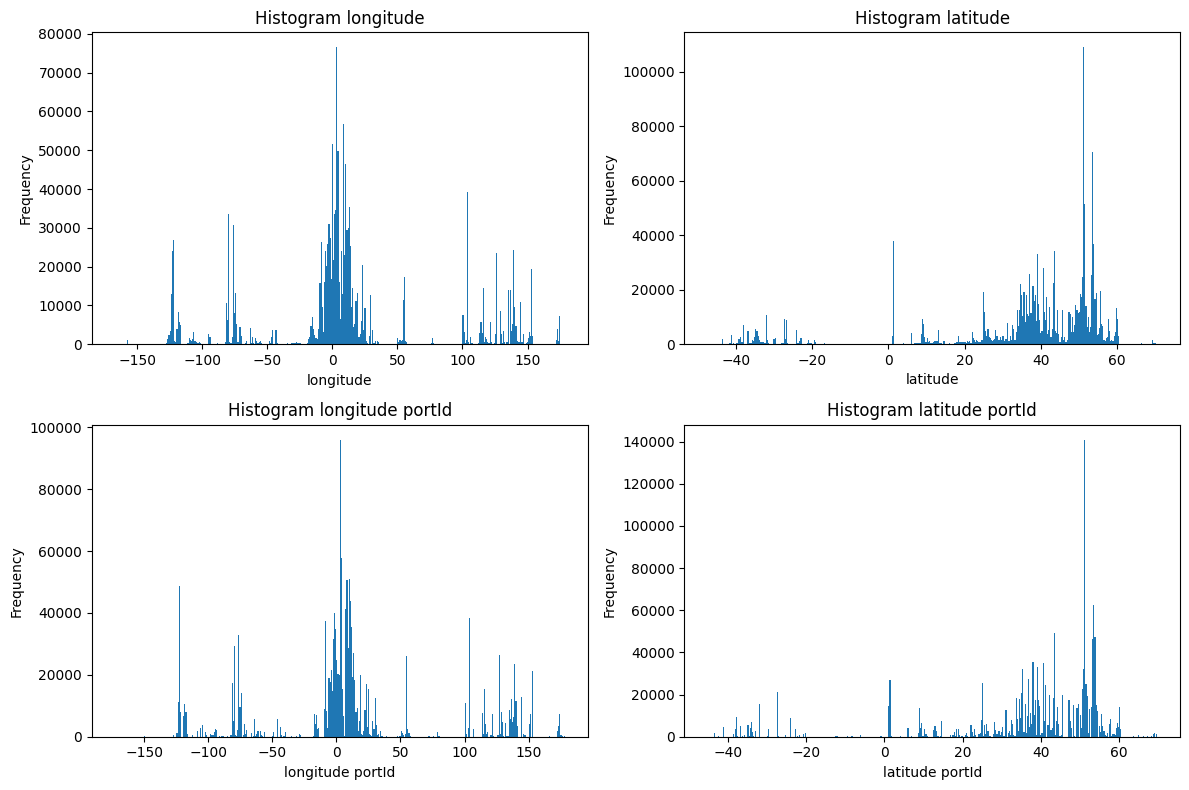

In [8]:
print(train_df.columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['longitude'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram longitude', xlabel = 'longitude')

train_df['latitude'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram latitude', xlabel = 'latitude')

train_df['portLongitude'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram longitude portId', xlabel= 'longitude portId')

train_df['portLatitude'].plot(kind='hist', bins=400, ax=axes[1,1], title='Histogram latitude portId', xlabel = 'latitude portId')

plt.tight_layout()
plt.show()


An important insight we gain is that the port location and position data for each vessel have a similar distribution. This would indicate high correlation. Also most of the data is located around Europe. Which is expected as much trade and shippings occurs here. 

Then we look at the number intantces for vesselId, portId, shippingLineId and Navstat 

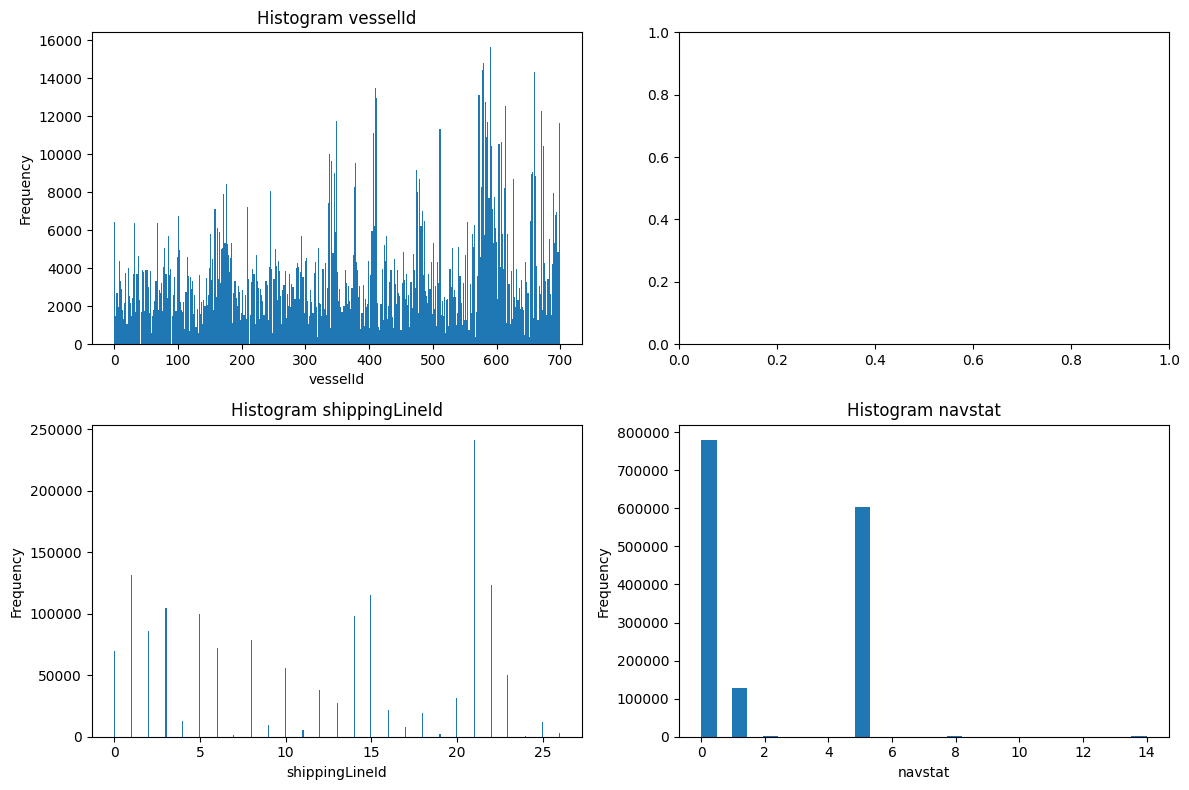

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['vesselId'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram vesselId', xlabel = 'vesselId')


train_df['shippingLineId'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram shippingLineId', xlabel= 'shippingLineId')

train_df['navstat'].plot(kind='hist', bins=29, ax=axes[1,1], title='Histogram navstat', xlabel= 'navstat')


plt.tight_layout()
plt.show()


Here we see that some vessels have higher frequency than others. From navstat we see that the vessels are mostly ankered, which will give a SOG equal to zero.  

Furthermore we plot for sog, cog, heading and rot to get insight into the movement of the vessels

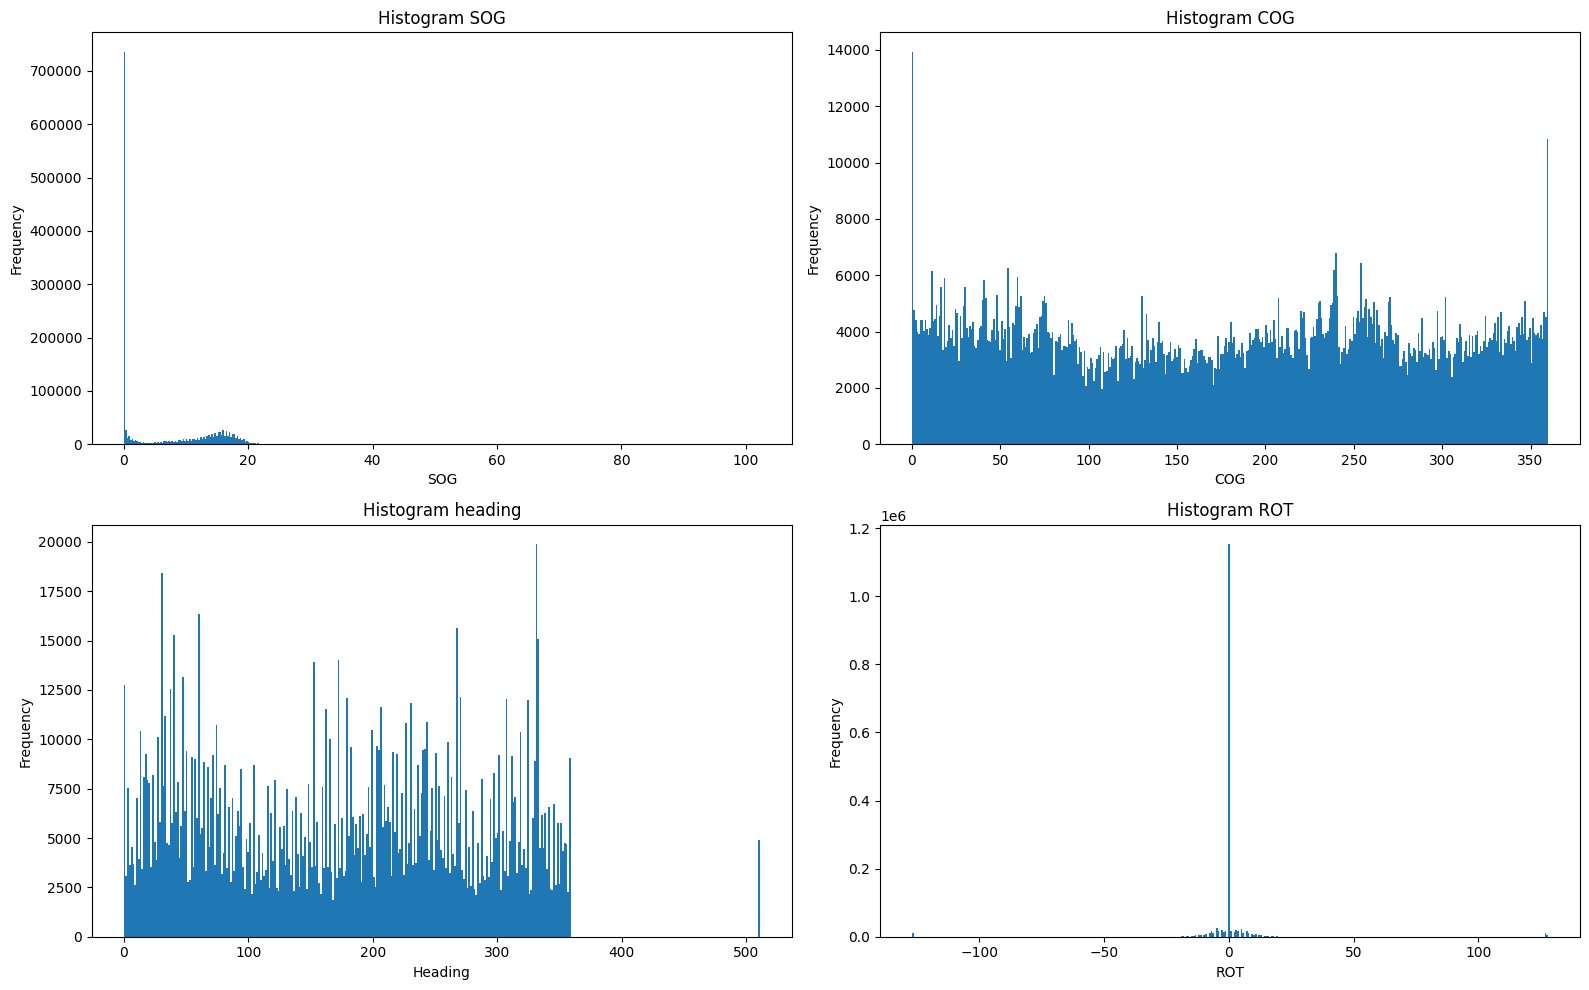

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

train_df['sog'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram SOG', xlabel = 'SOG')

train_df['cog'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram COG', xlabel = 'COG')

train_df['heading'].plot(kind='hist', bins=360, ax=axes[1,0], title='Histogram heading', xlabel = 'Heading')

train_df['rot'].plot(kind='hist', bins=360, ax=axes[1,1], title='Histogram ROT', xlabel= 'ROT')

plt.tight_layout()
plt.show()

Here we see some important outliers which need to be cleaned so that the data is of better quality. From 'Dataset defintions and explanation.pdf' we known which values we have clean. For ROT we have to remove all vessel with value {-128, -127, 127}, for heading we remove {511}, for SOG we remove {102.3}, for heading we remove {511} and lastly we remove on cog for {360}. 

#### Data cleaning and data intuition

For data cleaning we remove the outliers we saw in the indvidual features. For data intiution we saw no anomalies outside of the insufficient data, so we do no specific changes in the data regarding data intuition. 

In [11]:
#some data cleaning provided from the dataset and definiton document 
train_df.replace({'rot': {127: np.nan, -127: np.nan, -128: np.nan},
               'sog': {102.3: np.nan},
               'cog': {360: np.nan},
               'heading': {511: np.nan}}, inplace=True)

train_df = train_df.dropna()


#### Exploration of pairs of features 

Now we have looked at the each individual feature. It gives us insight in patterns and tendencies in the data, but not much of the interaction between the features. To explore how features interact we will provide a correlation plot and try to gain some insight in the data.

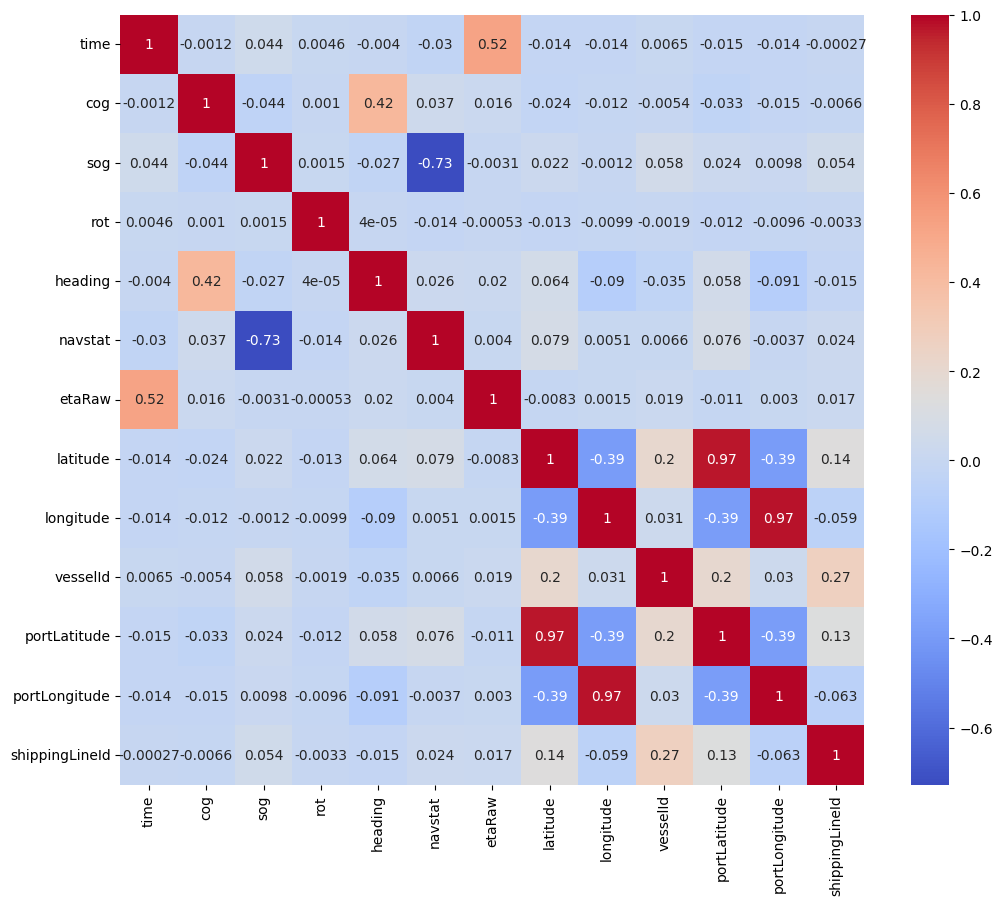

In [12]:
corr = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

From the correlation matrix we observe clear dependencies. Such as the position (longitude/latitude) and the destination (port longitude/latitude). We see some correlation between vesselId and latitude/longitude. However this correlation matrix is not that much of interest as we see no dependencies in the future. To add this feature have to do some feature engineering. 

### Feature engineering 

Since our problem is to predict vessel trajectory five days into the future we have to find a way to describe trajectory evolution in the dataset. We do this by extending the dataset with batches. In each batch we have the regular dataset with additional lag features for time, longitude and latitude extracted from the next instance of each vessel. Here we introduce a vaiable 'time_diff' which indicates how far into the future the model should predict. By introducing these lagged features the dataset describes where each vessel are in the future relative to a previous instance. We choose to do lagged features for $2^{k}$ where $k \in \{1,2,3,4,5,6,7,8\}$ for extreme gradient boost and $k \in \{1,2,3,4,5,6,7,8,9,10\}$ for RandomForestRegressor. Difference in time between each time step is around 20 minutes so for $k = 8$ we have lagged features for approximately 5 days and with $k=10$ we have lagged features for 14 days. When constructing a model later it we want it to predict the longitude and latitude based on the last known observations and the time difference. Hopefully, the model see the patterns in the lagged features. When experimenting with lagged features XGB worked best with 8 and RandomForest with 10. The reason is not clear, but it seems like RandomForest need more historical data to uncover patterns and tendencies in the data.

In [13]:
X_train = train_df.copy() #copy training data 
#introduce lagged features
X_train[['time_y', 'longitude_y', 'latitude_y']] = (X_train[['time', 'vesselId', 'longitude', 'latitude']].groupby(by = 'vesselId').shift(-1)) 
#since groupby remove vesselId we add it again
X_train['vesselId'] = X_train['vesselId']
#compute time between lagged feature and the original dataset
X_train['time_diff'] =  (X_train['time_y'] - X_train['time']).dt.total_seconds()
#remove nan values
X_train = X_train.dropna()
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: #do the same procedure for different lagged features an
    print(k , end = '\r')
    X_k = train_df.copy()
    X_k[['time_y', 'longitude_y', 'latitude_y']] = (X_k[['time', 'vesselId', 'longitude', 'latitude']].groupby(by = 'vesselId').shift(-2**k))
    X_k['vesselId'] = train_df['vesselId']
    X_k['time_diff'] =  (X_k['time_y'] - X_k['time']).dt.total_seconds()
    X_k = X_k.dropna()
    X_train = pd.concat([X_train, X_k]) #use pd.concat to create a large dataset containing the lagged features
display(X_train)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portLatitude,portLongitude,shippingLineId,time_y,longitude_y,latitude_y,time_diff
0,2024-01-01 00:00:25,284.0,0.7,0.0,88.0,0,2024-01-09 23:00:00,-34.74370,-57.85130,54,-33.587500,-71.618889,23,2024-01-01 06:09:08,-56.77210,-35.16787,22123.0
1,2024-01-01 00:00:36,109.6,0.0,-6.0,347.0,1,2024-12-29 20:00:00,8.89440,-79.47939,196,8.967000,-79.533000,15,2024-01-01 00:33:36,-79.47938,8.89446,1980.0
2,2024-01-01 00:01:45,111.0,11.0,0.0,112.0,0,2024-01-02 09:00:00,39.19065,-76.47567,442,39.232500,-76.558889,14,2024-01-01 00:24:37,-76.39602,39.16657,1372.0
3,2024-01-01 00:03:11,96.4,0.0,0.0,142.0,1,2024-12-31 20:00:00,-34.41189,151.02067,117,-34.462500,150.899444,1,2024-01-01 01:03:14,151.02005,-34.41206,3603.0
4,2024-01-01 00:03:51,214.0,19.7,0.0,215.0,0,2024-01-25 12:00:00,35.88379,-5.91636,365,35.783000,-5.817000,15,2024-01-01 23:52:46,-13.93870,31.96349,85735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479412,2024-05-04 10:39:11,162.2,15.8,3.0,163.0,1,2024-05-01 19:30:00,47.52720,-122.44279,654,47.267222,-122.406667,17,2024-05-07 23:56:53,-122.41612,47.26898,307062.0
1479415,2024-05-04 10:39:12,77.0,12.3,0.0,79.0,0,2024-05-04 14:00:00,53.79502,6.65382,290,53.563611,8.554722,14,2024-05-07 23:59:02,8.13324,53.80223,307190.0
1479455,2024-05-04 10:39:20,246.1,0.2,0.0,202.0,1,2024-05-02 21:00:00,-32.04356,115.67438,100,-32.047500,115.740833,1,2024-05-07 23:57:42,115.67331,-32.04476,307102.0
1479458,2024-05-04 10:39:20,89.9,14.6,-6.0,88.0,0,2024-05-05 18:30:00,50.40544,-3.20824,495,53.346111,7.198333,15,2024-05-07 23:58:40,6.31700,53.62411,307160.0


Our test set only contains time, vesselId and scaling factor. We need to extract some data from the training set to the test set so that they are compatible. For each row in the test data we merge the last known data on vesselId. Now test data will have the same features as training, excluding the target variables which are latitude and longitude. 

In [14]:
last_values_df = train_df.groupby('vesselId').tail(1)
merged_data = pd.merge(test_df, last_values_df, on='vesselId', how='left', suffixes=('', '_last'))
test_data = merged_data
test_data['time_x'] = test_data['time_last'].copy()
test_data['time_y'] = test_data['time'].copy()
test_data = test_data.drop(columns = ['time', 'time_last'])
test_data['time_diff'] = (pd.to_datetime(test_data['time_y']) - pd.to_datetime(test_data['time_x'])).dt.total_seconds()
test_data['time_to_arrival'] = (pd.to_datetime(test_data['time_x']) - pd.to_datetime(test_data['etaRaw'])).dt.total_seconds()
display(test_data)

,ID,vesselId,scaling_factor,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,portLatitude,portLongitude,shippingLineId,time_x,time_y,time_diff,time_to_arrival
0,0,89,0.3,179.6,0.0,0.0,344.0,5,2024-05-06 10:45:00,31.14647,-81.49789,31.140556,-81.496667,1,2024-05-07 23:48:16,2024-05-08 00:03:16,900.0,133396.0
1,1,635,0.3,24.7,0.0,0.0,214.0,5,2024-05-01 23:00:00,14.81694,120.29625,14.808333,120.279444,18,2024-05-07 23:57:16,2024-05-08 00:06:17,541.0,521836.0
2,2,606,0.3,8.0,18.7,0.0,6.0,0,2024-05-08 12:45:00,38.27895,10.78280,42.098889,11.780833,21,2024-05-07 23:59:08,2024-05-08 00:10:02,654.0,-45952.0
3,3,552,0.3,321.3,0.1,0.0,70.0,1,2024-05-07 01:15:00,-43.53785,172.83522,-43.606111,172.716111,15,2024-05-07 23:52:34,2024-05-08 00:10:34,1080.0,81454.0
4,4,1,0.3,291.0,0.3,0.0,275.0,2,2024-05-09 04:00:00,48.53320,-6.12003,48.380556,-4.474167,25,2024-05-07 23:51:29,2024-05-08 00:12:27,1258.0,-101311.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,51734,52,0.1,5.7,15.6,0.0,10.0,0,2024-05-12 20:00:00,26.22892,-79.40341,53.563611,8.554722,0,2024-04-27 21:40:48,2024-05-12 23:59:58,1304350.0,-1289952.0
51735,51735,117,0.1,87.6,14.4,0.0,88.0,0,2024-05-10 12:00:00,41.64055,143.29942,42.988611,144.353611,1,2024-04-26 13:29:25,2024-05-12 23:59:58,1420233.0,-1204235.0
51736,51736,620,0.1,76.9,15.9,0.0,78.0,0,2024-05-10 06:50:00,35.33234,142.69115,36.425278,140.621111,8,2024-04-28 19:17:28,2024-05-12 23:59:58,1226550.0,-991952.0
51737,51737,584,0.1,232.0,22.0,-13.0,234.0,0,2024-05-08 19:00:00,59.26571,21.98971,53.952222,10.869167,22,2024-05-07 19:22:20,2024-05-12 23:59:58,448658.0,-85060.0


Now we want to look at the correlation matrix for the lagged features as well. 

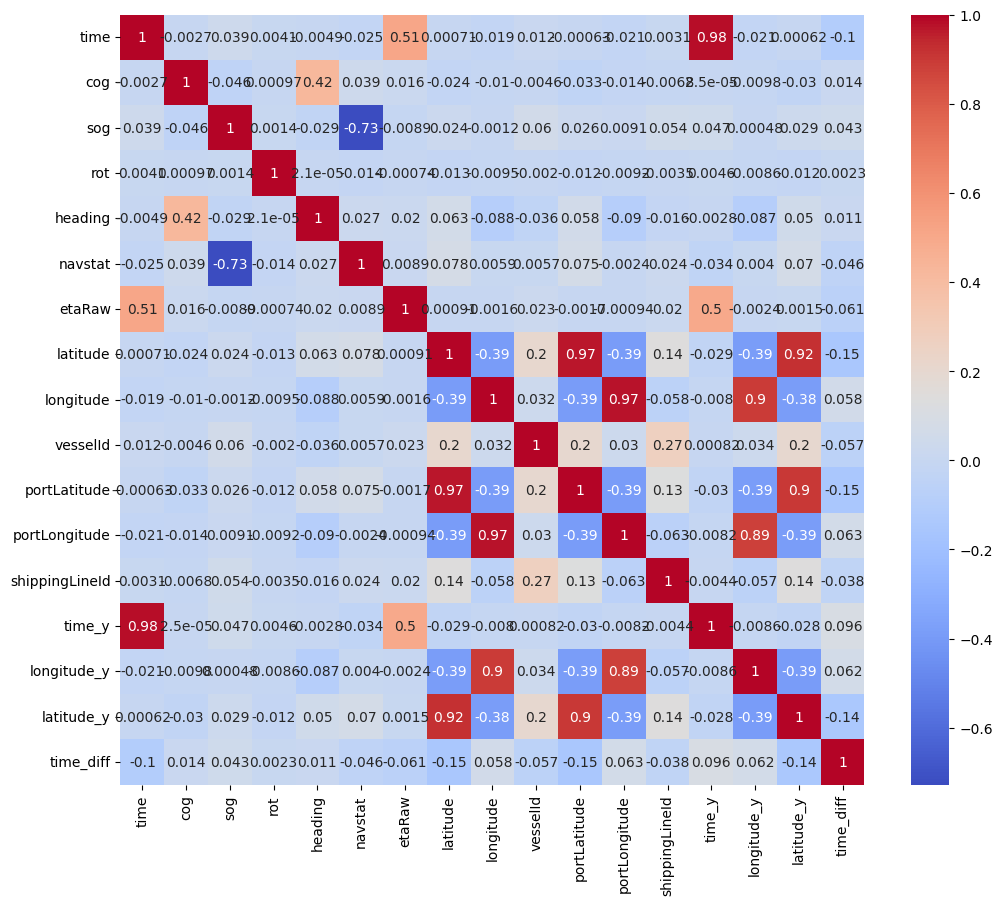

In [15]:
corr = X_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

From the correlation matrix we see strong correlation between the lagged position and the previous position, as well for the destination. This indicates that previous latitude and longitude should be great predictors for future latitude and longitude. There other strong correlations aswell such as SoG and Navstat. Which makes sense since we have many instances where sog and Navstat are zero. 

## Type of predictors

Since we have a regression time-series problem with a rather complicated data structure we choose models which are easy construct and train. We chose extreme gradient boost and Randomforest.

### XGBoost 

For XGBoost we choose the hyperparameters max_depth, eta, min_child_weight, subsample and num_boosting_round
* max_depth: indicates how deep each tree can be  
* eta: is the learning rate of each boosting round
* min_child_weight: minimum weight recuired for the tree to make a new node
* subsample: the fraction of observations (the rows) to subsample at each step
* num_boosting_round: amount of roads we want to boost our tree

When tuning the model we did not use XGB's CV function as it took a lot of time and we were quite short on that. So instead we noted which parameters we used in the kaggle submissions and then decided on which where optimal from there. 

 
| max_depth | min_child_weight | eta |num_boosting_rounds | subsample | kaggle score |
| - | - | - | - | -  | - |
| 7 | 1 | 0.01 |400| 1 | 122.60328 | 
| 13 | 1 | 0.01 |600| 1 | 102.13410 |
| 15 | 2 | 0.02 |800| 0.9 | 91.04299 |
| 13 | 2 | 0.02 |600| 0.9 | 89.31472 |
| 13 | 3 | 0.025 |800| 0.9 | 89.52668 |

We tried many more parameters tuning with the same results. It seems like the sweet spot for this model is with max_depth = 13, min_child_weight = 2, eta = 0.02, num_boosting_rounds = 600 and subsample = 0.9. 

If we had more time we would try a broader hyperparameter search with xgb built in functions. 


In [16]:
#extract data 
train_data = X_train.copy() 
#decide on features
features =  ['time_diff', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'latitude', 'longitude', 'portLatitude', 'portLongitude']
#decide on targets
targets = ['latitude_y', 'longitude_y']

#create x and y for model fit 
x = train_data[features]
y = train_data[targets]

#hyper parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 13,
    'eta':  0.02,
    'min_child_weight': 3,
    'subsample': 0.9,
    'n_jobs': -1
}
#training
dtrain = xgb.DMatrix(x, label = y)
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_boost_round= 600, evals = evals, verbose_eval= 10)

[0]	train-rmse:51.41782
[10]	train-rmse:42.36179
[20]	train-rmse:35.00974
[30]	train-rmse:29.05233
[40]	train-rmse:24.23809
[50]	train-rmse:20.35563
[60]	train-rmse:17.23795
[70]	train-rmse:14.74115
[80]	train-rmse:12.76414
[90]	train-rmse:11.18397
[100]	train-rmse:9.93575
[110]	train-rmse:8.94539
[120]	train-rmse:8.16546
[130]	train-rmse:7.55168
[140]	train-rmse:7.05396
[150]	train-rmse:6.66493
[160]	train-rmse:6.33578
[170]	train-rmse:6.05239
[180]	train-rmse:5.81105
[190]	train-rmse:5.61380
[200]	train-rmse:5.42995
[210]	train-rmse:5.27194
[220]	train-rmse:5.13112
[230]	train-rmse:4.99968
[240]	train-rmse:4.88426
[250]	train-rmse:4.78012
[260]	train-rmse:4.68393
[270]	train-rmse:4.58774
[280]	train-rmse:4.50772
[290]	train-rmse:4.43061
[300]	train-rmse:4.36322
[310]	train-rmse:4.28406
[320]	train-rmse:4.20530
[330]	train-rmse:4.13763
[340]	train-rmse:4.07331
[350]	train-rmse:4.01358
[360]	train-rmse:3.95070
[370]	train-rmse:3.90623
[380]	train-rmse:3.85898
[390]	train-rmse:3.80861
[

### Model interpretation  

For model interpretation we look at the hyperparameter search through kaggle and a feature importance plot for xgboost and Randomforest

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

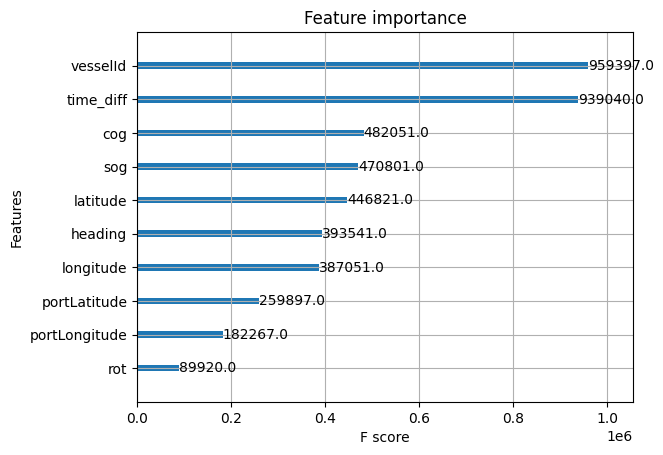

In [17]:
#save model
model.save_model('xgboost_model.json') 
xgb.plot_importance(model)

For XGBoost we see that the model heavily relies on vesselId and time_diff, but also the previous position. Is seems like the model finds patterns between vesselId, previous position and target time to predict the next position.

### Predictions

In [18]:
test_data['vesselId'] = test_data['vesselId'].apply(lambda x: int(x))
dtest = xgb.DMatrix(test_data[features])

prediction = model.predict(dtest)

In [19]:
test_df['latitude_predicted'] = prediction[:,0]
test_df['longitude_predicted'] = prediction[:,1]

display(test_df)

submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])
submission.to_csv('submission_10_11_xgb.csv', index = False)

,ID,vesselId,time,scaling_factor,latitude_predicted,longitude_predicted
0,0,89,2024-05-08 00:03:16,0.3,31.357094,-81.373741
1,1,635,2024-05-08 00:06:17,0.3,14.840569,120.041389
2,2,606,2024-05-08 00:10:02,0.3,38.423954,10.776381
3,3,552,2024-05-08 00:10:34,0.3,-43.555252,172.791855
4,4,1,2024-05-08 00:12:27,0.3,48.267845,-6.418616
...,...,...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1,51.864109,16.360939
51735,51735,117,2024-05-12 23:59:58,0.1,35.789650,-89.563057
51736,51736,620,2024-05-12 23:59:58,0.1,16.000179,19.216658
51737,51737,584,2024-05-12 23:59:58,0.1,58.764145,22.159941


Here is a plot of the timeseries for one of the vessels.

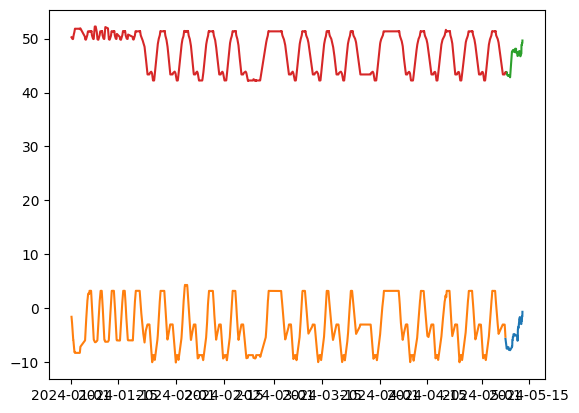

In [20]:
vessel = test_df['vesselId'].unique()[11]
vessel_data_test = test_df[test_df['vesselId'] == vessel]
vessel_data_train = train_df[train_df['vesselId'] == vessel]
plt.plot(vessel_data_test['time'],vessel_data_test['longitude_predicted'])
plt.plot(vessel_data_train['time'],vessel_data_train['longitude'])

plt.plot(vessel_data_test['time'],vessel_data_test['latitude_predicted'])
plt.plot(vessel_data_train['time'],vessel_data_train['latitude'])

### Feature importance

After running our code we see that the most importance features are ...

### Randomforest

We also used randomforest as a predictor. We started with a guess on the hyperparameters with n_estimators = 200 and max_depth = 20. This gave us good results and we experimented further. 

In [21]:
#create model with hyper parameters
#extract data 
train_data = X_train.copy() 
#decide on features
features =  ['time_diff', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'latitude', 'longitude', 'portLatitude', 'portLongitude']
#decide on targets
targets = ['latitude_y', 'longitude_y']

#create x and y for model fit 
x = train_data[features]
y = train_data[targets]
model = RandomForestRegressor(n_estimators=200, max_depth=19, n_jobs=-1, random_state=42, verbose=3)
model.fit(x,y)
prediciton = model.predict(test_data[features].astype(np.float32))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 15.2min


building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 30.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished


### Model interpretations RandomForrestRegressor

For model interpretation we use RandomForrestRegressor built in function for feature importance.

In [24]:
importance = model.feature_importances_

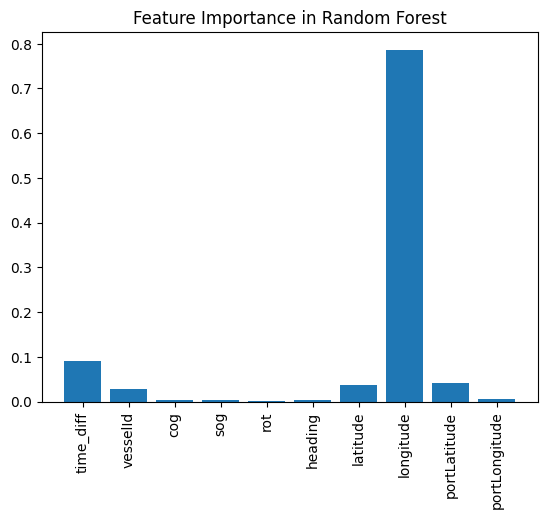

In [29]:
plt.bar(range(x.shape[1]), importance)
plt.xticks(range(x.shape[1]), x.columns, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

From the feature importance plot, we see that "longitude" has a significant larger importance than the other features. As for gradient boost, "time_diff" and "vesselId" is also important. 

It seems like the model heavily uses "longtitude" together with "time_diff" and "vesselId" to predict the next position.

### Predictions

In [22]:
prediction = prediciton
test_df['latitude_predicted'] = prediction[:,0]
test_df['longitude_predicted'] = prediction[:,1]

display(test_df)

submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])
submission.to_csv('submission_10_11_rf_200_19.csv', index = False)


,ID,vesselId,time,scaling_factor,latitude_predicted,longitude_predicted
0,0,89,2024-05-08 00:03:16,0.3,31.156645,-81.349890
1,1,635,2024-05-08 00:06:17,0.3,14.811848,120.298372
2,2,606,2024-05-08 00:10:02,0.3,38.537543,10.903973
3,3,552,2024-05-08 00:10:34,0.3,-43.547232,172.832688
4,4,1,2024-05-08 00:12:27,0.3,48.351344,-6.195079
...,...,...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1,52.619501,1.046253
51735,51735,117,2024-05-12 23:59:58,0.1,35.803365,-104.383401
51736,51736,620,2024-05-12 23:59:58,0.1,6.805626,119.536983
51737,51737,584,2024-05-12 23:59:58,0.1,58.649566,21.200404


Here is a plot of the timeseries for one of the vessels.

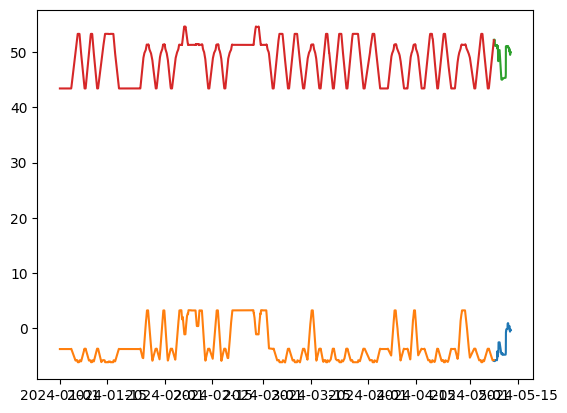

In [23]:
vessel = test_df['vesselId'].unique()[110]
vessel_data_test = test_df[test_df['vesselId'] == vessel]
vessel_data_train = train_df[train_df['vesselId'] == vessel]
plt.plot(vessel_data_test['time'],vessel_data_test['longitude_predicted'])
plt.plot(vessel_data_train['time'],vessel_data_train['longitude'])

plt.plot(vessel_data_test['time'],vessel_data_test['latitude_predicted'])
plt.plot(vessel_data_train['time'],vessel_data_train['latitude'])